# Tutorial 4.2: Postinhibitory Rebound

### Neuroscience goal:
- understand relationship of calcium conductance to bursting behavior and postinhibitory rebound

### Computational goal:
- gain practice writing and using functions
- analyze responses to variations of multiple parameters
- plot functions of 2 parameters

### Overview
- produce model thalamocortical neuron with T-type calcium current
    - assess response to single steps of applied current of variable size and baseline
    - simulate neuron within a function rather than within script
        - different levels of baseline current and step current can be manipulated elsewhere

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def reset_params():
    """reset global parameters and initialize simulation variables"""
    global g_leak, g_na, g_k, g_t, e_na, e_k, e_ca, e_leak, c_membrane
    
    g_leak = 10e-9         # Leak conductance, nS
    g_na = 3.6e-6          # Maximum sodium conductance, uS
    g_k = 1.6e-6           # Maximum potassium conductance, uS
    g_t = 0.22e-6          # Maximum T-type calcium conductance, uS
    e_na = 55e-3           # Sodium reversal potential, mV
    e_k = -90e-3           # Potassium reversal potential, mV
    e_ca = 120e-3          # Calcium reversal potential, mV
    e_leak = -70e-3        # Leak reversal potential, mV
    c_membrane = 100e-12   # Membrane capacitance, pF
    
reset_params()    

In [5]:
dt = 0.01e-3
t = np.arange(0, 0.75, dt)

### note on activation functions and gating variables

- activation functions for sodium and T-type calcium current are not included as dynamical equations because assumed to respond instantaneously to changes in membrane potential: 
    - $m = m_{\infty} = \alpha_m / (\alpha_m + \beta_m)$
    - $m_T = m_{T, \infty}$
    
- in this example, it is the long time constant for inactivation of the calcium current that will produce a slow timescale for burst duration
- membrane potential-depenence of all gating variables are:

### implementation of gating variables from PIR_Vdependence.m

In [17]:
# range of membrane potential
vm = np.arange(-0.1, 0.001, 0.001)

# sodium rate constants
alpha_m = np.where(vm == -0.035, 1e3, 1e5 * (vm + 0.035) /    # sodium activation
                   (1 - np.exp(-100 * (vm + 0.035))))       
beta_m = 4000 * np.exp(-(vm + 0.060) / 0.018)                 # sodium deactivation                                                
alpha_h = 350 * np.exp(-50 * (vm + 0.057))                    # sodium inactivation
beta_h = 5000 / (1 + np.exp(-100 * (vm + 0.028)))             # sodium deinactivation

# potassium rate constants
alpha_n = np.where(vm == -0.034, 500, 5e4 * (vm + 0.034) /    # potassium activation
                   (1 - np.exp(-100 * (vm + 0.034))))
beta_n = 625 * np.exp(-12.5 * (vm+ 0.044))                    # potassium inactivation

# from alpha and beta for each gating variable, find steady state values and time constants

m_ss = alpha_m / (alpha_m + beta_m)    # sodium activation variable steady state
tau_h = 1 / (alpha_h + beta_h)         # sodium inactivation time constant
h_ss = alpha_h / (alpha_h + beta_h)    # sodium inactivation variable steady state
tau_n = 1 / (alpha_n + beta_n)         # potassium activation time constant
n_ss = alpha_n / (alpha_n + beta_n)    # potassium activation variable steady state

mca_ss = 1 / (1 + np.exp(-(vm + 0.052) / 0.0074))    # calcium T-current activation variable steady state
hca_ss = 1 / (1 + np.exp(500 * (vm + 0.076)))        # calcium T-current inactivation variable steady state

# calcium T-current time constant has two terms
# for membrane potential < -80mV or > -80mV
# expressions yield 1 or 0 so only one term is used
tau_hca = np.where(vm < -0.080, np.exp(15 * (vm + 0.467)) * 1e-3, (28 + np.exp(-(vm + 0.022) / 0.0105)) * 1e-3)

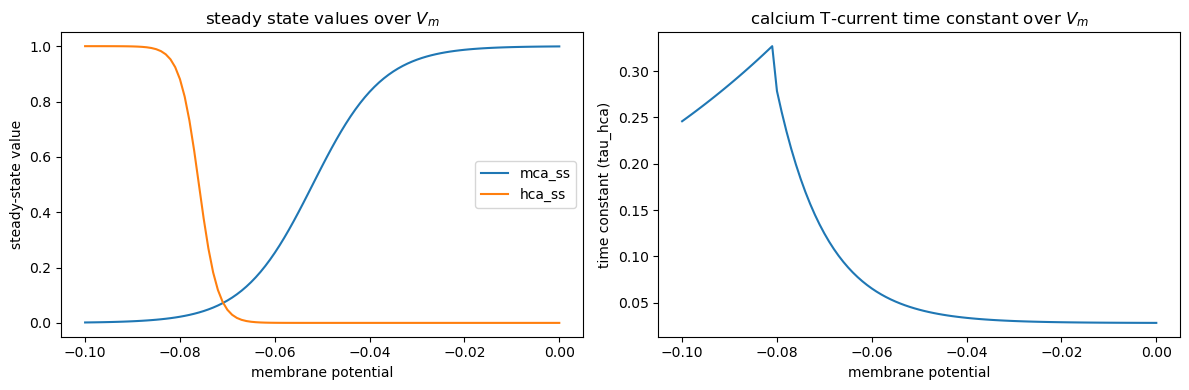

In [26]:
# plot functions
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# plot mca_ss and hca_ss
ax[0].plot(vm, mca_ss, label='mca_ss')
ax[0].plot(vm, hca_ss, label='hca_ss')
ax[0].set_xlabel('membrane potential')
ax[0].set_ylabel('steady-state value')
ax[0].legend()
ax[0].set_title('steady state values over $V_m$')

# plot tau_hca
ax[1].plot(vm, tau_hca)
ax[1].set_xlabel('membrane potential')
ax[1].set_ylabel('time constant (tau_hca)')
ax[1].set_title('calcium T-current time constant over $V_m$')

plt.tight_layout()

### a. produce a function that simulates the model neuron described above:
- for a period of 750ms
- function will take two args:
    - baseline current
    - current step
- applied current should be set to the baseline value from 0:250ms, increased by current step from 250:500, and return to baseline from 500:750ms
- function will return:
    - membrane potential as function of time
    - time vector

### b. produce code that loops through a range of values for the baseline current (-200:+200pA) and a range of values for current step (0:+100pA, added to baseline current)
- for each pair of parameters (baseline/current step), calculate total number of spikes produced during current step
    - if two or more spikes produced, calculate minimum ISI
    - plot functions of two variables
        - plot total number of spikes on one graph and minimum ISI on other graph
        - baseline current on x-axis and current step on y-axus
